Данный блокнот посвящён исследованию различных инициализаций графа

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import networkx as nx

In [ ]:
import sys 
sys.path += [
    '../libs/sublime',
    '../libs/imc-gae',
    '../src',
    # '.venv/'
]

In [ ]:
# while not os.getcwd().endswith('labevent'):
#     os.chdir('..')
# os.getcwd()

# sys.path.append('src')

# Считывание и предобработка

In [4]:
DROP_TIME_CLUSTER = True

In [5]:
df = pd.read_csv('../data/refined/wide/blood_chemistry_17.csv',
                 index_col=(0, 1)
                )

Выборка содержит данные о пацентах и образцах в количествах:

In [6]:
df.index.to_frame().nunique()

subject_id       91
specimen_id    2085
dtype: int64

In [7]:
subsam_to_ind = pd.Series(np.arange(df.shape[0]), index=df.index)
ind_to_subsam = pd.Series(df.index.values)

In [8]:
cols = [col for col, t in df.dtypes.items() if t == bool] 
df.loc[:, cols] = df[cols].astype(int)
df = pd.get_dummies(df)
if DROP_TIME_CLUSTER and 'time_cluster' in df.columns:
    df.drop('time_cluster', axis=1, inplace=True)
    
target_cols=['Potassium',
       'Sodium', 'Creatinine', 'Chloride', 'Urea Nitrogen', 'Bicarbonate',
       'Anion Gap', 'Glucose', 'Magnesium', 'Calcium, Total', 'Phosphate']

In [9]:
df.sample()

,,allinref,age,charttime,Potassium,Sodium,Creatinine,Chloride,Urea Nitrogen,Bicarbonate,Anion Gap,Glucose,Magnesium,"Calcium, Total",Phosphate,race_BLACK,race_HISPANIC,race_UNKNOWN,race_WHITE,gender_F,gender_M
subject_id,specimen_id,,,,,,,,,,,,,,,,,,,,
10020306,90467227,0,74.0,1447061,4.7,153.0,0.8,105.0,31.0,35.0,14.0,314.0,2.1,9.1,3.5,1,0,0,0,1,0


Поскольку для метрических моделей масштаб признаков имеет большое значение, отнормируем данные.
Для отдельно взятого здорового человека значения анализов распределены нормально. В случае патологии (в нашем случае - это большая часть наблюдений) распределение становится более сложным: многомодальным, содержит выбросы и т.п. По этой причине будем использовать RobustScaler на этом этапе

In [10]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

rs = ColumnTransformer([('scale_dense', RobustScaler(),
                        target_cols + ['age', 'charttime']),
                       ('pass', 'passthrough', ['allinref'])],
                      remainder='passthrough')
trdf = rs.fit_transform(df)

In [12]:
def describe_graph(G, draw=False, **draw_kw):
    res = {}
    res['av_clust'] = nx.average_clustering(G)
    res['is_directed'] = nx.is_directed(G)
    res['hist'] = nx.degree_histogram(G)
    res['density'] = nx.density(G)
        
    components = {'diameter': [], 'degree': []}
    res['ncomp'] = 0
    for component in nx.connected_components(G):
        res['ncomp'] += 1
        subg = nx.induced_subgraph(G, component)
        components['diameter'].append(nx.diameter(subg))
        components['degree'].append(nx.degree_histogram(subg))
        if draw:
            nx.draw_shell(subg, with_labels=False, **draw_kw)
            plt.show()
    res['components'] = components
    return res
        

In [14]:
def deghist(histlist, rng=(None, None)):
    histlist = histlist[slice(*rng)] 
    plt.bar(np.arange(len(histlist)), histlist)
    plt.title('Гистограмма степеней вершин')
    plt.show()
    

In [217]:
# def get_graph(X, gmode, edges=None, **kwargs):
#     if gmode == 'knn':
#         adj = kneighbors_graph(df, n_neighbors=10, mode='connectivity',
#                             n_jobs=-1)

slice(None, None)

slice(None, None, None)

## KNN graph

In [94]:
from sklearn.neighbors import VALID_METRICS
print(sorted(VALID_METRICS['brute']))

['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'cosine', 'dice', 'euclidean', 'hamming', 'haversine', 'jaccard', 'kulsinski', 'l1', 'l2', 'mahalanobis', 'manhattan', 'matching', 'minkowski', 'nan_euclidean', 'precomputed', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule']


### без разреживания

In [15]:
from sklearn.neighbors import kneighbors_graph

knn_graph = kneighbors_graph(trdf, n_neighbors=5, mode='connectivity',
                            n_jobs=-1)
G = nx.from_scipy_sparse_array(knn_graph)

In [17]:
res = describe_graph(G, False, node_size=100)

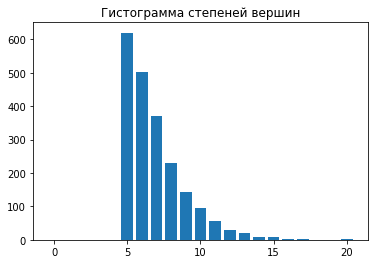

In [186]:
deghist(res['hist'])

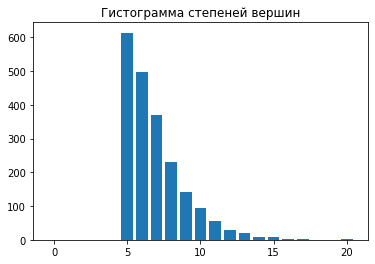

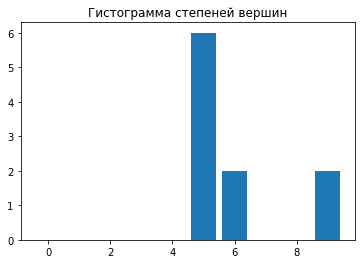

In [187]:
for component in res['components']['degree']:
    plt.title(f'Total number: {np.sum(component)}')
    deghist(component)


### cosine similarity

In [95]:
knn_graph = kneighbors_graph(trdf, n_neighbors=5, mode='distance',
                            n_jobs=-1,
                            metric='cosine')
# Gs = nx.from_scipy_sparse_array(knn_grap)


In [96]:
Gcos = nx.from_scipy_sparse_array(knn_graph)

In [101]:
cos = describe_graph(Gcos, False)

In [102]:
cos

{'av_clust': 0.46599819844424195,
 'is_directed': False,
 'hist': [0, 0, 0, 0, 0, 653, 516, 353, 256, 151, 77, 27, 29, 17, 3, 3],
 'density': 0.0032132451428492524,
 'ncomp': 1,
 'components': {'diameter': [20],
  'degree': [[0, 0, 0, 0, 0, 653, 516, 353, 256, 151, 77, 27, 29, 17, 3, 3]]}}

## Radial neighborhood

In [40]:
from sklearn.neighbors import radius_neighbors_graph
eps_graph = radius_neighbors_graph(trdf, 1.5, mode='connectivity',
                            n_jobs=-1)
Gr = nx.from_scipy_sparse_array(eps_graph)

In [54]:
epsns =  np.arange(1., 10., .5)
comps = []
for eps in epsns:
    eps_graph = radius_neighbors_graph(trdf, eps, mode='connectivity',
                            n_jobs=-1)
    Gr = nx.from_scipy_sparse_array(eps_graph)
    comps.append(len(list(nx.connected_components(Gr))))

    
    

In [88]:
G.is_directed()

False

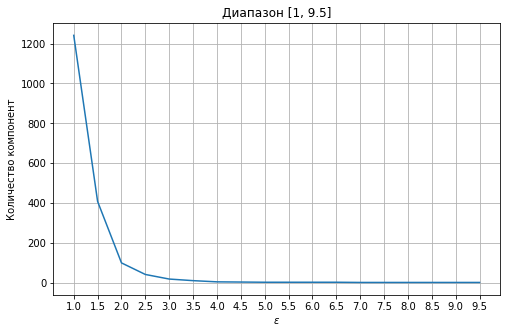

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(epsns, comps)
plt.title('Диапазон [1, 9.5]')
plt.grid()
plt.ylabel('Количество компонент')
plt.xlabel(r'$\epsilon$')
plt.xticks(epsns)
plt.yscale('linear')

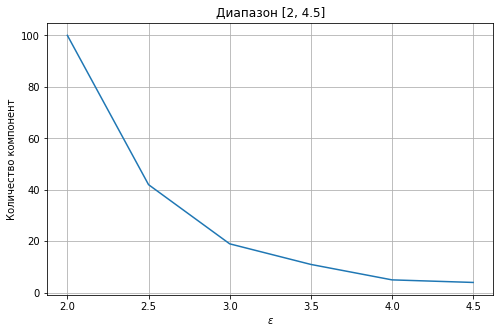

In [71]:
plt.figure(figsize=(8, 5))
sl = slice(2, 8)
plt.plot(epsns[sl], comps[sl])
plt.grid()
plt.title('Диапазон [2, 4.5]')
plt.ylabel('Количество компонент')
plt.xlabel(r'$\epsilon$')
plt.xticks(epsns[sl])
plt.yscale('linear')

In [74]:
eps_graph = radius_neighbors_graph(trdf, 4.5, mode='connectivity',
                            n_jobs=-1)
Gr = nx.from_scipy_sparse_array(eps_graph)

In [ ]:
resr = describe_graph(Gr, False)

## Объединение по признакам пациента

In [116]:
unidf = pd.read_csv('data/refined/wide/blood_chemistry_17.csv',
                 index_col=(0, 1)
                )
cols = [col for col, t in unidf.dtypes.items() if t == bool] 
unidf.loc[:, cols] = unidf[cols].astype(int)

In [210]:
def group_graph(df, pat_cols, to_discretize=None, index_cols=None, n=5,):
    if not to_discretize:
        to_discretize = ['age']
    if not index_cols:
        index_cols = ['subject_id', 'specimen_id']
    tmp = df[pat_cols]
    tmp.loc[:, to_discretize] //= n
    tmp.loc[:, to_discretize] *= n
    tmp = tmp.reset_index()
    idx = list(zip(tmp['subject_id'], tmp['specimen_id']))
    tmp.drop(['subject_id', 'specimen_id'], axis=1, inplace=True)
    tmp['index'] = idx
    tmp.iloc[:, -1] = tmp.iloc[:, -1].map(subsam_to_ind)
    tmp = tmp.groupby(pat_cols).aggregate(list)['index']
    return tmp

def complete_graph_from_components(components):
    edgelist = []
    for lst in components:
        g = nx.complete_graph(lst)
        edgelist.extend(nx.to_edgelist(g))
    G = nx.from_edgelist(edgelist)
    return G

### age & gender

In [211]:
pat_cols = [
    'age', 
    # 'race', 
    'gender'
]
to_discretize = ['age']

In [212]:
agge = group_graph(unidf, pat_cols)
G = complete_graph_from_components(agge)
agge_graph = describe_graph(G, )

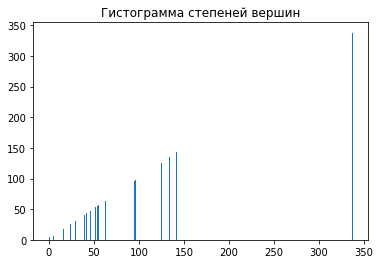

27

In [213]:
deghist(agge_graph['hist'])
agge_graph['ncomp']

### age & gender & race

In [214]:
pat_cols = [
    'age', 
    'race', 
    'gender'
]
aggera = group_graph(unidf, pat_cols)
G = complete_graph_from_components(aggera)
aggera_graph = describe_graph(G, )

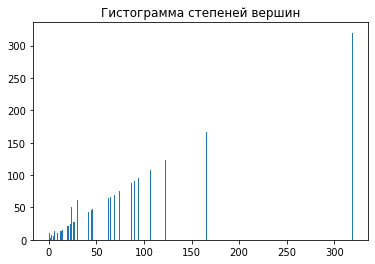

47

In [221]:
deghist(aggera_graph['hist'])
aggera_graph['ncomp']

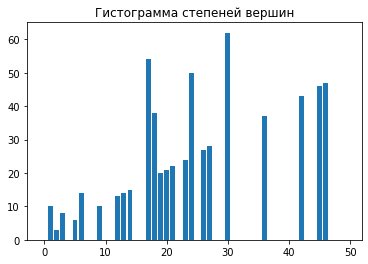

In [243]:
deghist(aggera_graph['hist'], (0, 50))

Следует заметить, что 47 компонент не включили в себя 2 изолированных узла (их надо включать отдельно)